#### Importaciones.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc,roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

#### Funciones.

In [44]:
# Función Grafica ROC
def plot_ROC(fpr,tpr,name,color,fig=(10,6)):
    if isinstance(fpr, (int, float)):
        roc_auc='ROC curve area = Un punto'
    else:
        roc_auc = 'ROC curve (area = %0.2f)' % auc(fpr, tpr)
    plt.figure(figsize=fig)
    plt.plot(fpr, tpr,'o-', label=roc_auc ,color=color,markersize=7)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falsos Positivos tasa (fpr)')
    plt.ylabel('Verdaderos Positivos tasa (tpr)')
    plt.title(f'Curva ROC: {name}')
    plt.legend(loc="lower right")
    plt.show()

# Funcion Grafica Matriz de Confusión.
def matcon(yt,yp,model):
    cm=confusion_matrix(yt, yp)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.show()
    fpr=cm[0,1]/(cm[0, 1]+cm[0,0])
    tpr=cm[1,1]/(cm[1,1]+cm[1,0])
    return fpr,tpr

# Función Calcula puntos de Curva ROC
def fRoc(yt,yp,umbrales):
    umbrales=np.array(umbrales).astype(float)
    umbrales= np.insert(umbrales, 0, np.inf)
    tpr=[]
    fpr=[]
    for u in umbrales:
        yd=(yp>= u).astype(int)
        cm=confusion_matrix(yt, yd)
        fpr.append(cm[0,1]/(cm[0,1]+cm[0,0]))
        tpr.append(cm[1,1]/(cm[1,1]+cm[1,0]))
    return np.array(fpr),np.array(tpr),umbrales

#### Lectura de Datos de Transacciones comerciales con tarjeta de crédito.

In [45]:
df=pd.read_csv('creditcard.csv')
df.shape

(284807, 31)

#### Descripción de Variables.

In [46]:
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

#### Matriz de Correlación

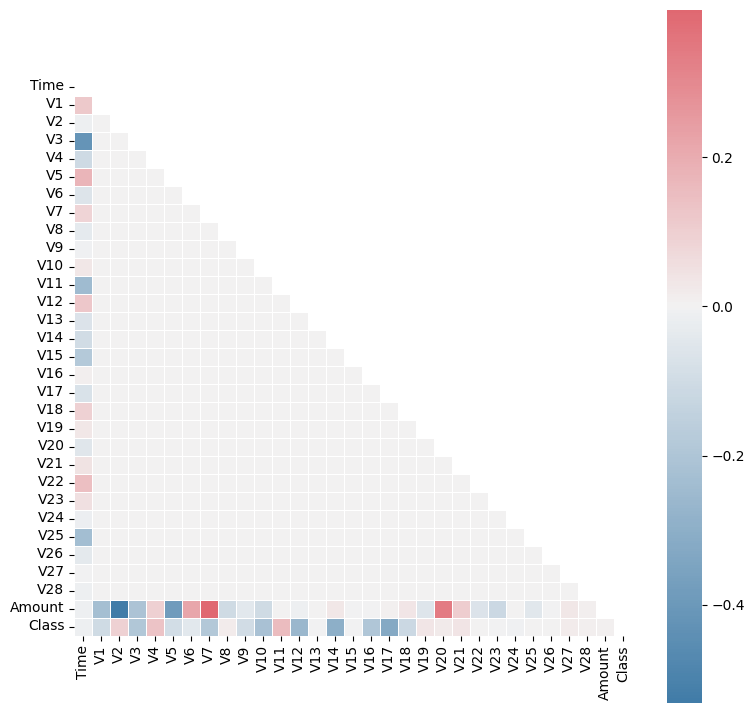

In [47]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(9, 9))

cmap = sns.diverging_palette(240, 10, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, annot=False)

plt.show()

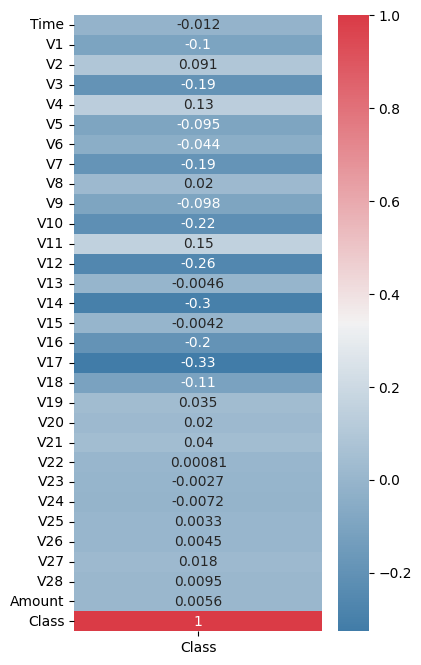

In [48]:
target_corr = pd.DataFrame(df.corr()['Class'], index=df.corr().index)

plt.figure(figsize=(4,8))
sns.heatmap(target_corr, annot=True, cmap=cmap)

plt.show()

#### Separación de variables predictivas y objetivo. Categorías de variable objetivo y Balance.

In [49]:
X=df.drop(['Class'],axis=1)
y=df['Class']
clases,frec=np.unique(y,return_counts=True)
print(f'Cantidad de Registros: {y.shape[0]}\n')
print(f'Número de Categorías en "y": {len(clases)}')
print(f'Categorías en "y": {clases}\n')
print(f'Balance {df.Class.value_counts().to_string()} \n')
print(f'Balance en % {df.Class.value_counts(normalize=True).to_string()}')

Cantidad de Registros: 284807

Número de Categorías en "y": 2
Categorías en "y": [0 1]

Balance Class
0    284315
1       492 

Balance en % Class
0    0.998273
1    0.001727


<span style='color:salmon'>Se ve que "Class" está muy desbalanceada ya que por cada 578 negativos hay sólo 1 positivo. **( 0.17 % )**     
Esto va a afectar la cantidad de puntos de la curva ROC, no va a ser tan suave; y con pocos umbrales (puntos).</span>

#### Separación de registros para prueba. (Antes de TODO)
El modelo se utiliza para ***PREDECIR*** y cuando se predice se tiene como dato ***SOLAMENTE*** **X**.  
Por lo tanto se necesita ***simular*** esta situación para tener una idea mas ***"justa"*** del error que se tendrá en la determinación de los **"y"**.  
Por otra parte se utiliza ***Stratify*** para que los conjuntos ***"train"*** y ***"test"*** de la partición tengan una distribución parecida.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,random_state=42,stratify=y)

#### Optimización del Modelo
Solo se optimiza ***"max_depth"*** , pues el tiempo de optimización para este df sino será excesivo. 

In [60]:
# Definición del modelo vacío
tree = DecisionTreeClassifier()

# Definir los parámetros a ajustar
param_tree = {
    'max_depth': list(range(1,21)),
}

grid_tree= GridSearchCV(tree, param_grid=param_tree, cv=5, scoring='accuracy')

# Realizar la búsqueda de parámetros óptimos
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [61]:
print('Profundidad Óptima')
print(grid_tree.best_params_['max_depth'])

Profundidad Óptima
5


Accuracy media= 0.9993855471921702
Accuracy desviación= 0.00007973
Accuracy test= 0.9994908886626171


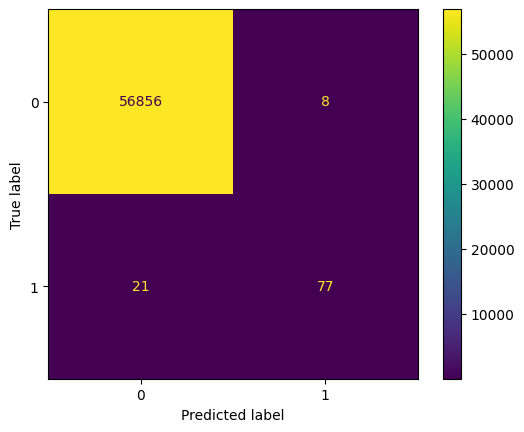

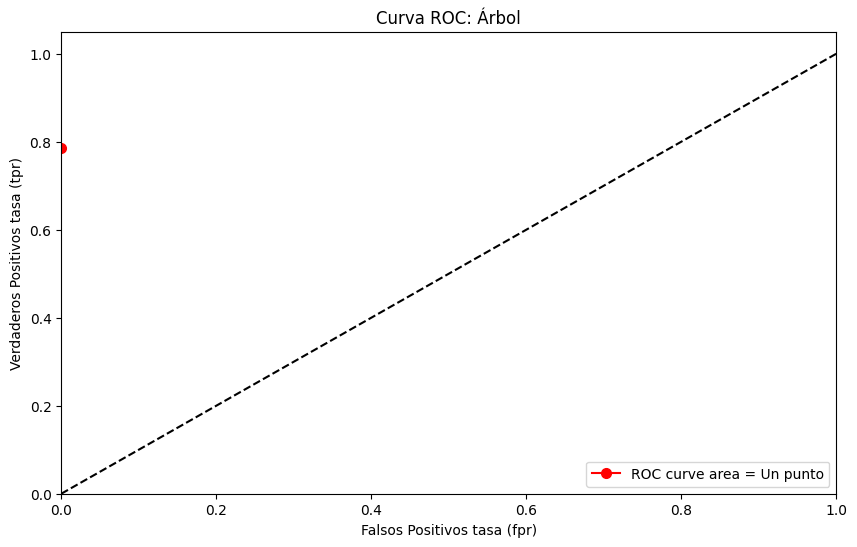

fpr= 0.00014068655036578504  tpr=0.7857142857142857


In [53]:
# Se instancia el mejor modelo. max_depth =6
tree_m = DecisionTreeClassifier(max_depth=6)

# Calculo con cross validation accuracy media y desviación SOLO DA IDEA DEL SCORE PROMEDIO DEL MODELO; NO MEJORA EL AJUSTE 
acc_tree_values=cross_val_score(tree_m, X_train, y_train, cv=5) 
acc_mean=acc_tree_values.mean()
acc_std=acc_tree_values.std()
print(f'Accuracy media= {acc_mean}')
print(f'Accuracy desviación= {acc_std:.8f}')

# SE VUELVE A AJUSTAR IMPORTANTE!!! PORQUE SE USA TODO EL X_train
tree_m.fit(X_train, y_train)

# Predicciones binarias
ytree=tree_m.predict(X_test)  # predict = predict_proba pero para umbral >0.5 ver más abajo.

# Accuracy del AJUSTE aplicado al TEST
acc_tree=accuracy_score(y_test,ytree)
print(f'Accuracy test= {acc_tree}')

# Grafico Matriz de Confusión
fpr_tree,tpr_tree=matcon(y_test,ytree,tree_m)
plot_ROC(fpr_tree,tpr_tree,'Árbol','red')
print(f'fpr= {fpr_tree}  tpr={tpr_tree}')


In [54]:
print(classification_report(y_test, ytree,digits=4))

              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9997     56864
           1     0.9059    0.7857    0.8415        98

    accuracy                         0.9995     56962
   macro avg     0.9528    0.8928    0.9206     56962
weighted avg     0.9995    0.9995    0.9995     56962



#### Ahora lo mismo pero probabilisticamente
Distancia de un punto a recta 0-1:
$$d=\frac{tpr-fpr}{\sqrt{2}}$$

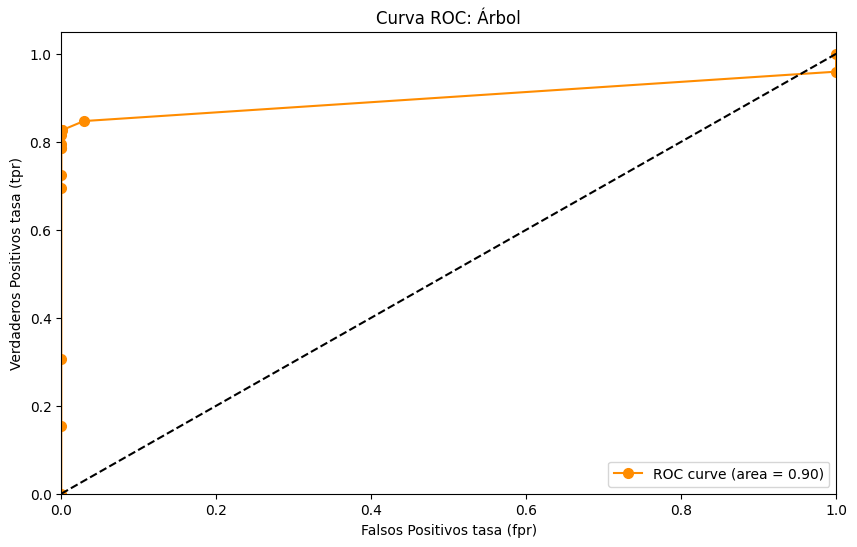

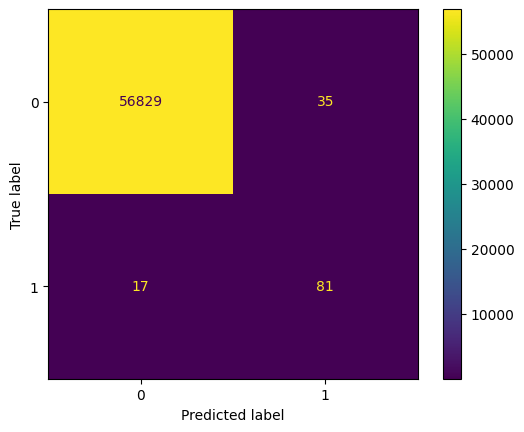

              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9995     56864
           1     0.6983    0.8265    0.7570        98

    accuracy                         0.9991     56962
   macro avg     0.8490    0.9130    0.8783     56962
weighted avg     0.9992    0.9991    0.9991     56962

fpr_tree = 0.0006155036578503095,    tpr_tree = 0.826530612244898,    Umbral óptimo = 0.020618556701030927

 Cantidad de umbrales: 14
tprs [0.             0.15306122449  0.30612244898  0.69387755102
 0.724489795918 0.785714285714 0.785714285714 0.795918367347
 0.816326530612 0.826530612245 0.826530612245 0.84693877551
 0.959183673469 1.            ]
fprs [0.             0.000052757456 0.000052757456 0.000105514913
 0.000105514913 0.00014068655  0.000158272369 0.000175858188
 0.000193444007 0.000615503658 0.001354108047 0.029034186832
 0.99956035453  1.            ]
tpr-fprs [ 0.              0.153008467033  0.306069691523  0.693772036108
  0.724384281006  0.7855735

In [64]:
# Predicciones probabilisticas
ytreepp=tree_m.predict_proba(X_test)

# Calcula los umbrales utilizando linspace
# umb = np.linspace(1, 0, 1000)

# Dejo que roc_curve calcule los umbrales significativos.
fpr_tree, tpr_tree, umbral_tree = roc_curve(y_test, ytreepp[:,1])

# umb=[1.00000000e+00, 9.57446809e-01, 9.49771689e-01,8.84615385e-01,5.38461538e-01,3.88888889e-01,3.06122449e-02,2.04081633e-02, 2.81717420e-04, 0.00000000e+00]
# fpr_tree, tpr_tree, umbral_tree = fRoc(y_test, ytreepp[:,1],umb)

# Se grafica la curva ROC
plot_ROC(fpr_tree,tpr_tree,'Árbol','DarkOrange')

# Se calcula el umbral optimo segun el criterio
indice_optimo_tree = np.argmax(tpr_tree - fpr_tree)
umbral_optimo_tree = umbral_tree[indice_optimo_tree]

# Se determina las predicciones segun el umbral optimo calculado segun criterio.
ytreepU=(ytreepp[:,1] >=umbral_optimo_tree).astype(int)

# Se Calcula y muestra matriz de confusion y reporte.
fpr_treep,tpr_treep=matcon(y_test,ytreepU,tree_m)
print(classification_report(y_test, ytreepU,digits=4))

# Imprime FPR y TPR para el umbral optimo, umbrales utilizados, umbrales significativos.
print(f'fpr_tree = {fpr_treep},    tpr_tree = {tpr_treep},    Umbral óptimo = {umbral_optimo_tree}')
print(f'\n Cantidad de umbrales: {umbral_tree.size}')
with np.printoptions(precision=12, suppress=True):
    print(f'tprs {tpr_tree}')
    print(f'fprs {fpr_tree}')
    print(f'tpr-fprs {tpr_tree-fpr_tree}')
    print(f'umbrales {umbral_tree}')
fpr_tpr_Unicos=len(set(list(zip(fpr_tree,tpr_tree))))
print(f'(fpr,tpr) únicos = {fpr_tpr_Unicos}')

#### Modelo Knn

In [56]:
# Definición del modelo vacío
knn = KNeighborsClassifier()
# Modelo personalizado es lo que me permite pipeline.
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', knn)])

# Definir los parámetros a ajustar
param_knn = {
    'knn__n_neighbors': list(range(1,21)),
}

grid_knn= GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='accuracy')

# Realizar la búsqueda de parámetros óptimos
grid_knn.fit(X_train, y_train)

print("Mejores parámetros encontrados:")
print(grid_knn.best_params_)

Mejores parámetros encontrados:
{'knn__n_neighbors': 2}


Accuracy media= 0.999508437753736
Accuracy desviación= 0.00007924
Accuracy test= 0.9994908886626171


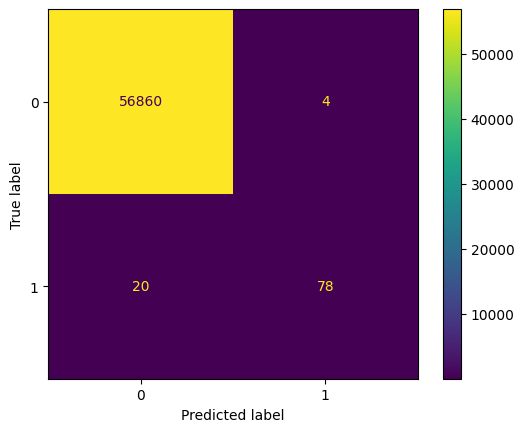

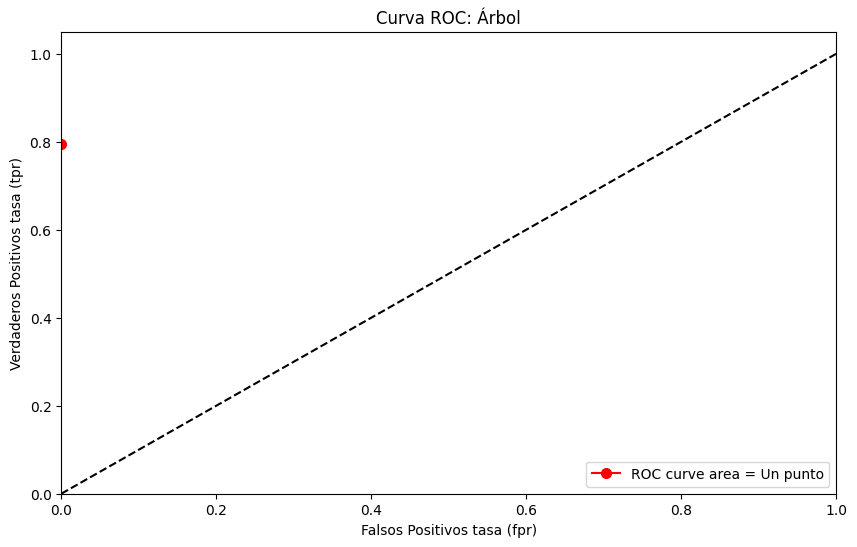

fpr= 0.000070343275  tpr=0.795918367347


In [57]:
# Se instancia el mejor modelo.n_neighbors=2
knn = KNeighborsClassifier(n_neighbors=2)

# Modelo personalizado es lo que me permite pipeline.
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', knn)])

# Calculo con cross validation accuracy media y desviación SOLO DA IDEA DEL SCORE PROMEDIO DEL MODELO; NO MEJORA EL AJUSTE 
acc_knn_values=cross_val_score(pipe_knn, X_train, y_train, cv=5) 
acc_mean_knn=acc_knn_values.mean()
acc_std_knn=acc_knn_values.std()
print(f'Accuracy media= {acc_mean_knn}')
print(f'Accuracy desviación= {acc_std_knn:.8f}')

# SE VUELVE A AJUSTAR IMPORTANTE!!! PORQUE SE USA TODO EL X_train
pipe_knn.fit(X_train, y_train)

# Predicciones binarias
yknn=pipe_knn.predict(X_test)

# Accuracy del AJUSTE aplicado al TEST
acc_knn=accuracy_score(y_test,yknn)
print(f'Accuracy test= {acc_tree}')

# Grafico Matriz de Confusión
fpr_knn,tpr_knn=matcon(y_test,yknn,pipe_knn)
plot_ROC(fpr_knn,tpr_knn,'Árbol','red')
print(f'fpr= {fpr_knn:.12f}  tpr={tpr_knn:.12f}')


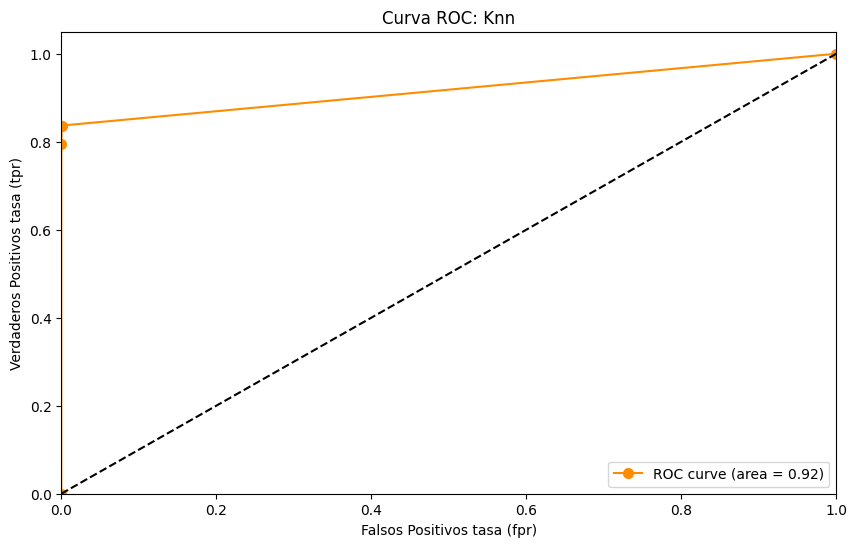

indice optimo knn= 2


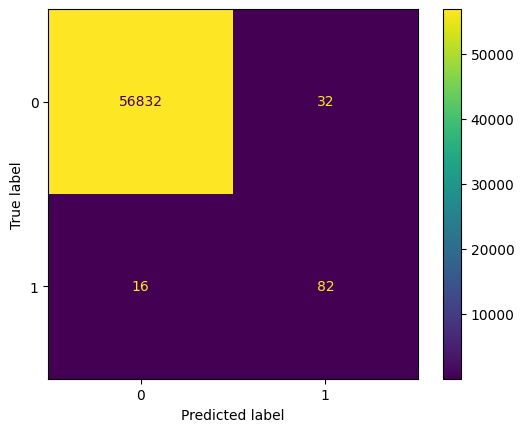

              precision    recall  f1-score   support

           0     0.9997    0.9994    0.9996     56864
           1     0.7193    0.8367    0.7736        98

    accuracy                         0.9992     56962
   macro avg     0.8595    0.9181    0.8866     56962
weighted avg     0.9992    0.9992    0.9992     56962

fpr_knn = 0.0005627462014631402,    tpr_knn = 0.8367346938775511,    Umbral óptimo = 0.5
Umbrales= [inf 1.  0.5 0. ],
 
 Cantidad de umbrales: 4
tprs [0.             0.795918367347 0.836734693878 1.            ]
fprs [0.             0.000070343275 0.000562746201 1.            ]
tpr-fprs [0.             0.795848024072 0.836171947676 0.            ]
umbrales [inf 1.  0.5 0. ]
(fpr,tpr) únicos = 4


In [58]:
# Predicciones probabilisticas
yknnp=pipe_knn.predict_proba(X_test)

fpr_knn, tpr_knn, umbral_knn = roc_curve(y_test, yknnp[:,1],)

plot_ROC(fpr_knn,tpr_knn,'Knn','DarkOrange')

indice_optimo_knn = np.argmax(tpr_knn - fpr_knn)
umbral_optimo_knn = umbral_knn[indice_optimo_knn]
print(f'indice optimo knn= {indice_optimo_knn}')

# Se determina las predicciones segun el umbral optimo calculado segun criterio.
yknnpU=(yknnp[:,1] >=umbral_optimo_knn).astype(int)

# Se Calcula y muestra matriz de confusion y reporte.
fpr_knnp,tpr_knnp=matcon(y_test,yknnpU,pipe_knn)
print(classification_report(y_test, yknnpU,digits=4))

# Imprime FPR y TPR para el umbral optimo, umbrales utilizados, umbrales significativos.
print(f'fpr_knn = {fpr_knnp},    tpr_knn = {tpr_knnp},    Umbral óptimo = {umbral_optimo_knn}')
print(f'Umbrales= {umbral_knn},\n \n Cantidad de umbrales: {umbral_knn.size}')
with np.printoptions(precision=12, suppress=True):
    print(f'tprs {tpr_knn}')
    print(f'fprs {fpr_knn}')
    print(f'tpr-fprs {tpr_knn-fpr_knn}')
    print(f'umbrales {umbral_knn}')
fpr_tpr_Unicos=len(set(list(zip(fpr_knn,tpr_knn))))
print(f'(fpr,tpr) únicos = {fpr_tpr_Unicos}')

